In [22]:
import pandas as pd
import numpy as np
import nltk
import pickle
import re
import emoji

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [5]:
# Download the stopwords for English language
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aktha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
# Set the maximum number of words to keep based on word frequency
from sklearn.utils import resample


max_words = 10000

# Set random seed for reproducibility
np.random.seed(42)

# Load the data from the CSV file
df = pd.read_csv('C:/Sentiment-Analysis-Model/datasets/datasetEN.csv')

# Separate the data into positive, negative, and neutral examples
positive_examples = df[df['sentiment'] == 'positive']
negative_examples = df[df['sentiment'] == 'negative']
neutral_examples = df[df['sentiment'] == 'neutral']

# Resample the examples to the desired number
pos = 25000
neg = 30000
neu = 18000
positive_examples = resample(positive_examples, n_samples=pos, random_state=42)
negative_examples = resample(negative_examples, n_samples=neg, random_state=42)
neutral_examples = resample(neutral_examples, n_samples=neu, random_state=42)

# Concatenate the resampled examples back into a single DataFrame
df_resampled = pd.concat([positive_examples, negative_examples, neutral_examples])


# Preprocess the text
def preprocess_text(text):
    # Check if text is not null
    if isinstance(text, str):
        # Remove special characters and convert to lowercase
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        # Join tokens back into a string
        text = " ".join(tokens)
    return text

# Apply preprocessing to the text column
df_resampled['text'] = df_resampled['text'].apply(preprocess_text)

# Remove rows with null values in 'text' column
df_resampled = df_resampled.dropna(subset=['text'])

# Split the data into text and labels
x = df_resampled['text'].values
y = df_resampled['sentiment'].values

# Convert the labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Get the maximum sequence length
maxlen = max(len(x) for x in x_train)
print('maxlen:', maxlen)
# Pad sequences to have the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

maxlen: 128


<Axes: >

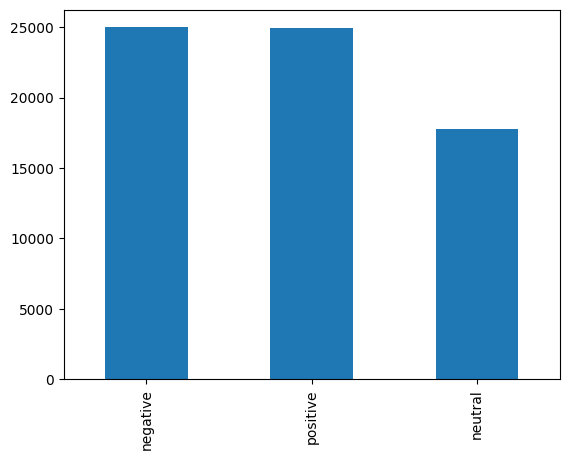

In [42]:
df_resampled['sentiment'].value_counts().plot.bar()

In [61]:
# Define the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(set(df['sentiment'])), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 128, 128)          1280000   
                                                                 
 conv1d_5 (Conv1D)           (None, 124, 128)          82048     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                      

In [62]:
# Define callbacks
filename = 'sentiment_analysis_modelEN.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001)
callbacks = [checkpoint, learning_rate_reduction]

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/5
910/910 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8681
Epoch 1: val_loss improved from inf to 0.17987, saving model to sentiment_analysis_modelEN.h5
910/910 [==============================] - 44s 47ms/step - loss: 0.3194 - accuracy: 0.8681 - val_loss: 0.1799 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 2/5
909/910 [============================>.] - ETA: 0s - loss: 0.1272 - accuracy: 0.9552
Epoch 2: val_loss improved from 0.17987 to 0.16002, saving model to sentiment_analysis_modelEN.h5
910/910 [==============================] - 43s 47ms/step - loss: 0.1272 - accuracy: 0.9552 - val_loss: 0.1600 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 3/5
910/910 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9771
Epoch 3: val_loss improved from 0.16002 to 0.15668, saving model to sentiment_analysis_modelEN.h5
910/910 [==============================] - 42s 47ms/step - loss: 0.0664 - accuracy: 0.9771 - val_loss: 0.1567 - val_accuracy: 0.9487 

In [93]:
# Load the best model
model = load_model(filename)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict classes for test data
y_pred = model.predict(x_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
print("Confusion Matrix:")
print(confusion_mat)

# Calculate precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), predicted_classes, average=None)
recall = recall_score(np.argmax(y_test, axis=1), predicted_classes, average=None)
f1 = f1_score(np.argmax(y_test, axis=1), predicted_classes, average=None)

# Print precision, recall, and F1-score for each class
for i, label in enumerate(set(df['sentiment'])):
    print(f"Class: {label}")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1-score:", f1[i])
    print()

Test Loss: 0.1566849797964096
Test Accuracy: 0.9487249851226807
455/455 [==============================] - 3s 7ms/step
Confusion Matrix:
[[5744  194  167]
 [  50 3379   70]
 [ 109  156 4680]]
Class: neutral
Precision: 0.9730645434524818
Recall: 0.9408681408681409
F1-score: 0.9566955363091272

Class: negative
Precision: 0.9061410565835345
Recall: 0.9657044869962846
F1-score: 0.9349750968456004

Class: positive
Precision: 0.9517998779743746
Recall: 0.9464105156723963
F1-score: 0.9490975461366863



In [92]:
# Save the trained model and the tokenizer to disk
model.save('sentiment_analysis_modelEN.h5')
with open('tokenizerEN.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [94]:
# Load model and tokenizer
with open('tokenizerEN.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = load_model('sentiment_analysis_modelEN.h5')

In [95]:
new_text = 'good'
new_text = preprocess_text(new_text)
print('new_text:', new_text)
new_text = tokenizer.texts_to_sequences([new_text])  # Convert text to sequences of integers
new_text = pad_sequences(new_text, maxlen=maxlen)
# Make the prediction
prediction = model.predict(new_text)[0]

# Get the predicted sentiment and confidence level
sentiments = ['Negative', 'Neutral', 'Positive']
sentiment = sentiments[np.argmax(prediction)]
confidence = np.max(prediction)

# Display the result
print(f'{sentiment} ({confidence * 100:.2f}%)')

new_text: good
1/1 [==============================] - 0s 146ms/step
Positive (61.96%)
